In [1]:
import os
os.chdir("..")

In [2]:
import seaborn as sns

from sim import quick_season, Params

## Basic correlations and simulated stats

In a moment, we're going to be chasing fairly small effect sizes, which will require monte carlo methods - 
simulating hundreds of seasons and averaging them out. During this process we lose access to individual season
data, so let's spend a bit of time looking into a single season to understand some basics.

This game is run with default parameters, listed below. The critical one right now is "MATCHMAKING_SPREAD":
given an ordered list of all teams, this term represents how many positions teams are allowed to matchmake with.

MMOLB's matchmaking spread is 6.

In [3]:
for a in dir(Params):
    if a[0] != "_":
        print(f"{a}: {getattr(Params, a)}")

AVERAGE_HITRATE: 0.2
CURRENT_ITERATION: 0
GAME_COUNT: 100
GOODNESS_WEIGHT: 0.7
ITERATIONS: 1000
LEAGUE_SIZE: 100
MATCHMAKING_SPREAD: 6
MULTIPROCESSING_POOL_SIZE: 10
STAT_WEIGHTS: [0.6, 0.3, 0.1, 0.0]
load_constants: <function Params.load_constants at 0x0000020191F0D9E0>


*For an explaination of the underlying sim, see about_the_sim.ipynb*

A single league-season is 100 teams of 15 players each, playing 100 games. Below we can see a "player chart", showing 
attributes and basic stats.

*Note: this chart includes pitchers. For all future analysis, we'll focus on batters and batter stats.*

In [4]:
Params.MATCHMAKING_SPREAD = 6
team_df, player_df = quick_season()
display(player_df)
batters = player_df.loc[player_df["is_pitcher"] == False]

,team,scale,goodness,attr_0,attr_1,attr_2,attr_3,at_bats,hits,average,is_pitcher
0,1,0.5,0.753610,0.785081,0.785552,0.468953,0.375604,654,114,0.174312,True
1,1,0.5,0.795318,0.918383,0.748571,0.197167,0.576399,635,95,0.149606,True
2,1,0.5,0.510077,0.694727,0.091157,0.658933,0.439515,677,137,0.202363,True
3,1,0.5,0.288726,0.132216,0.389596,0.925179,0.307316,718,178,0.247911,True
4,1,0.5,0.742140,0.755547,0.879961,0.248232,0.258606,644,104,0.161491,True
...,...,...,...,...,...,...,...,...,...,...,...
1495,100,0.5,0.636053,0.861888,0.361168,0.105694,0.751368,333,78,0.234234,False
1496,100,0.5,0.616915,0.560135,0.773041,0.489218,0.381201,322,69,0.214286,False
1497,100,0.5,0.186077,0.130585,0.045592,0.940484,0.295088,316,39,0.123418,False
1498,100,0.5,0.348819,0.168080,0.592630,0.701814,0.371971,305,61,0.200000,False


### Single-season correlations

We already have enough correlations to confirm some basic correlations. For instance, the relationship between 

#### Correlation

The primary metric we are going to be looking at is **correlation**. The correlation between two variables is how much they're linked. The closer to 1 the more they are tied together. In the below plot, we can see an example: the correlation between total number of hits and hit rate is very tight! They're not perfectly correlated, however. There is a significant **confounder**: players have different numbers of plate appearances, and thus two players with an identical rate can have different numbers of hits.

In this sim there is only a few sources of variation between numbers of plate appearances, and so our correlation plot has a very tight spread with almost no outliers, and the actual correlation between hit rate and hits is around 0.9. Contrast this with the correlation between plate appearances and hits - having more opportunities means more hits, but the correlation is about 0.4 and this has a much more scattered chart.

The correlation between hit rate and total hits is 0.910
The correlation between plate appearances and total hits is 0.474


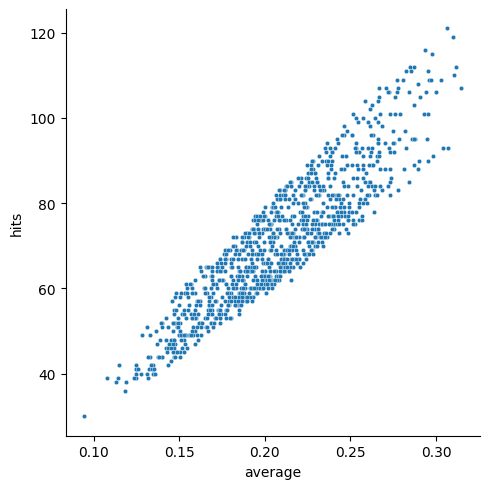

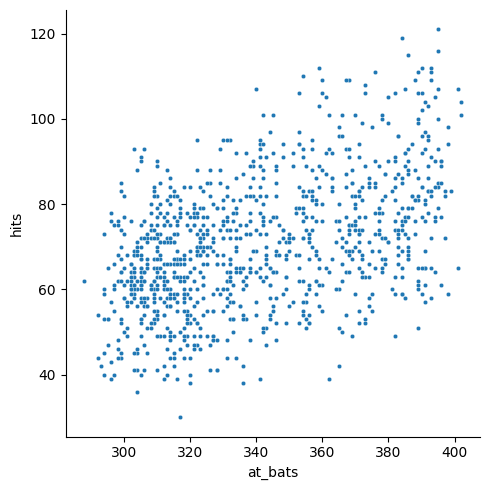

In [5]:
print(f"The correlation between hit rate and total hits is {batters[['hits', 'average']].corr().iat[0, 1]:.3f}")
p = sns.relplot(data=batters, y="hits", x="average", s=10)

print(f"The correlation between plate appearances and total hits is {batters[['hits', 'at_bats']].corr().iat[0, 1]:.3f}")
p = sns.relplot(data=batters, y="hits", x="at_bats", s=10)

### Attributes

One of the most important questions we can ask in MMOLB is "how good is this player". Unlike in Blaseball, where we could introspect a player's attributes directly and understand exactly how much raw capability each player had, MMOLB only gives us performance stats. These correlate to a player's attributes, but not precisely. More importantly, the sources and ways that the stats are distorted relative to the attributes are understandable - this set of experiments is meant to explore a few of those.

Let's start by looking at some very basic correlations from our single season of data. Note that players have four attributes, known as "attr_0", "attr_1", "attr_2", and "attr_3". These have descending order of importance: attr_0 is 60% of a player's "goodness", and attr_3 has no effect whatsoever.

The weighted composite of all four attributes is called **goodness**, and is what is used by the sim to determine the odds of a player either hitting a home run or striking out. (The only two outcomes in this sim.)

### Attribute correlations

As expected, the attributes correlate with our stats pretty closely. Goodness is actually used by the sim, and thus is tightly correlated with hit rate. Attr_0 is 60% of goodness, so it's less tightly correlated (the other attributes are confounders) but it still is correlated. Attr_3 is meaningless, and represents a kind of control - the correlation is near 0.

Correlation for goodness: 0.825
Correlation for attr_0: 0.738
Correlation for attr_1: 0.361
Correlation for attr_2: 0.152
Correlation for attr_3: 0.043


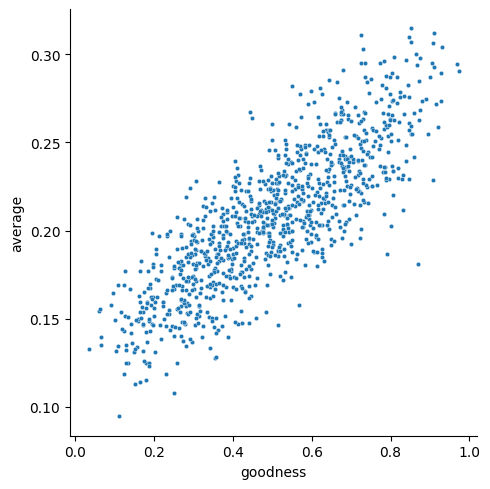

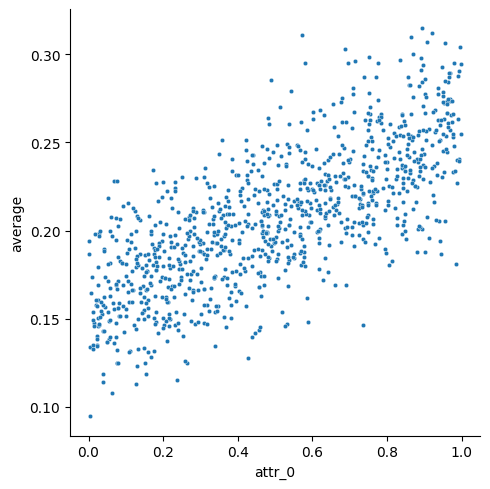

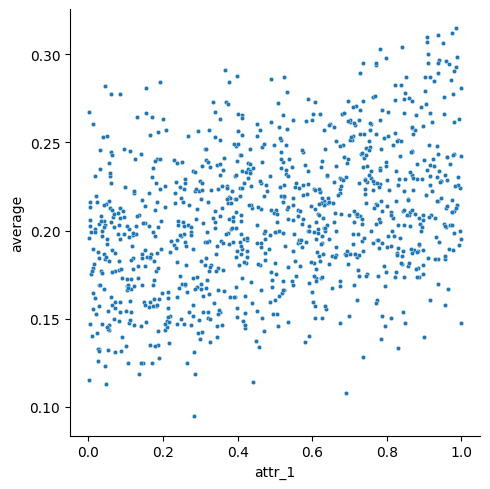

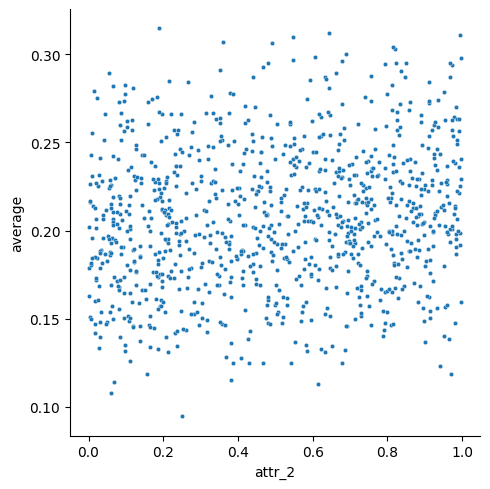

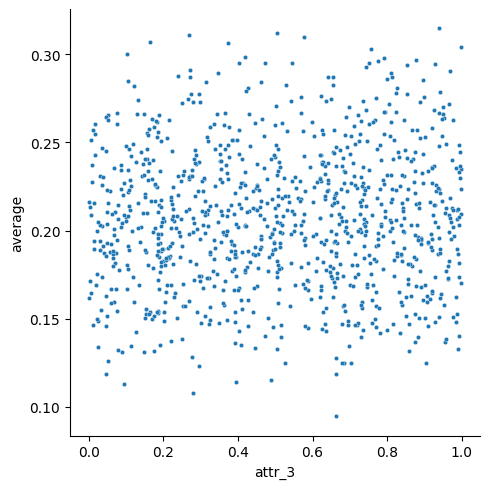

In [6]:
for attr in ["goodness"] + [f"attr_{i}" for i in range(4)]:
    p = sns.relplot(data=batters, x=attr, y="average", s=10)
    print(f"Correlation for {attr}: {batters[[attr, 'average']].corr().iat[0, 1]:.3f}")

## Goodness

Note that because all four attributes are rolled independently and then summed, player goodness follows a not-quite-bell curve. Most players are somewhere along the middle, and several rolls would need to align to get a goodness higher than 0.8 or lower than 0.2.

<Axes: xlabel='goodness', ylabel='Count'>

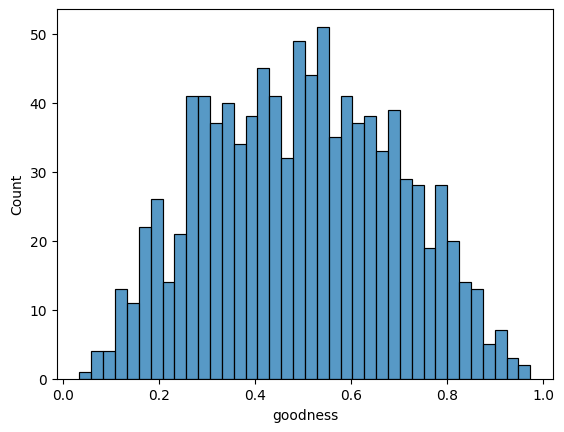

In [7]:
sns.histplot(data=batters, x="goodness", binwidth = 0.025)